# 41-wav-embedding
> A first pass at studying wave file embeddings

In this file, we explore the embeddings generated from the audio files.  We perform unsupervised learning based on the embeddings generated from a wav2vec2 model.

In [ ]:
#all_no_test
#modeling packages
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Model
import soundfile as sf
import torch
import librosa

#data science packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.plot
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
import seaborn as sns

#other python packages
import os.path
import glob

## Run example code from Wav2Vec2Model on https://huggingface.co/transformers/model_doc/wav2vec2.html#transformers.Wav2Vec2Model
It's markdown, if you want to run and test it, convert below chunk into code mode

```
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from datasets import load_dataset
import soundfile as sf

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

input_values = processor(ds["speech"][0], return_tensors="pt").input_values  # Batch size 1
hidden_states = model(input_values).last_hidden_state
```

### Load two same teacher audio and one different teacher audio on accre

In [ ]:
# File constants
base_prefix = os.path.expanduser('/data/p_dsi/wise/data/resampled_audio_16khz/')
#get list of audio files
audio_files_list = glob.glob(base_prefix + '*.wav')

In [ ]:
audio_files_list[:6]

['/data/p_dsi/wise/data/resampled_audio_16khz/134-2.wav',
 '/data/p_dsi/wise/data/resampled_audio_16khz/264-4.wav',
 '/data/p_dsi/wise/data/resampled_audio_16khz/038-4.wav',
 '/data/p_dsi/wise/data/resampled_audio_16khz/083-2.wav',
 '/data/p_dsi/wise/data/resampled_audio_16khz/058-4.wav',
 '/data/p_dsi/wise/data/resampled_audio_16khz/051-4b.wav']

### Choose two 038 teacher audio files and one 123-4 teacher audio files

In [ ]:
audio0081 = glob.glob(base_prefix + '008-1.wav')[0]
a0081, r0081 = sf.read(audio0081)

audio0082 = glob.glob(base_prefix + '008-2.wav')[0]
a0082, r0082 = sf.read(audio0082)

audio0271 = glob.glob(base_prefix + '027-1.wav')[0]
a0271, r0271 = sf.read(audio0271)

In [ ]:
a0081

array([0.037323  , 0.06390381, 0.08743286, ..., 0.        , 0.        ,
       0.        ])

### Initialize the processor and model

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Get embeddings for three audio files and rearrange them into 3 dimension torch

In [ ]:
sampling_rate = 16000
segment0081 = np.floor(len(a0081) / (4*sampling_rate))
seg0081 = torch.zeros(int(segment0081), 199, 768)
for i in range(int(segment0081)):
    start_index = i * 4 * sampling_rate
    end_index = start_index + 4 * sampling_rate
    input_values = processor(a0081[start_index:end_index], return_tensors="pt", sampling_rate = sampling_rate).input_values  # Batch size 1
    hidden_states = model(input_values).last_hidden_state
    seg0081[i, :, :] = hidden_states[0, :, :]

segment0082 = np.floor(len(a0082) / (4*sampling_rate))
seg0082 = torch.zeros(int(segment0082), 199, 768)
for i in range(int(segment0082)):
    start_index = i * 4 * sampling_rate
    end_index = start_index + 4 * sampling_rate
    input_values = processor(a0082[start_index:end_index], return_tensors="pt", sampling_rate = sampling_rate).input_values  # Batch size 1
    hidden_states = model(input_values).last_hidden_state
    seg0082[i, :, :] = hidden_states[0, :, :]

segment0271 = np.floor(len(a0271) / (4*sampling_rate))
seg0271 = torch.zeros(int(segment0271), 199, 768)
for i in range(int(segment0271)):
    start_index = i * 4 * sampling_rate
    end_index = start_index + 4 * sampling_rate
    input_values = processor(a0271[start_index:end_index], return_tensors="pt", sampling_rate = sampling_rate).input_values  # Batch size 1
    hidden_states = model(input_values).last_hidden_state
    seg0271[i, :, :] = hidden_states[0, :, :]

### Take a look at their shape

In [ ]:
print(seg0081.shape, seg0082.shape,seg0271.shape)

torch.Size([204, 199, 768]) torch.Size([181, 199, 768]) torch.Size([239, 199, 768])


### Check one point of embedding matrix for three audio files

In [ ]:
seg0081[203, :, :]

tensor([[ 0.2045,  0.0713, -0.3099,  ..., -0.1692, -0.0256,  0.0019],
        [ 0.0038,  0.0227, -0.2089,  ..., -0.0963, -0.0023,  0.0235],
        [-0.1203, -0.0675, -0.0259,  ...,  0.0859,  0.1672, -0.0148],
        ...,
        [ 0.2339, -0.1056, -0.0480,  ..., -0.0156, -0.0687, -0.1793],
        [-0.0968,  0.0047, -0.4402,  ...,  0.1389,  0.1596,  0.1803],
        [ 0.0911,  0.0360, -0.1544,  ..., -0.2217,  0.0550,  0.0287]],
       grad_fn=<SliceBackward>)

In [ ]:
seg0271[238, :, :]

tensor([[-0.0295, -0.0220,  0.1228,  ..., -0.2607,  0.0404, -0.0865],
        [-0.0257, -0.0217,  0.1192,  ..., -0.2637,  0.0456, -0.0990],
        [-0.0281, -0.0182,  0.1229,  ..., -0.2672,  0.0458, -0.0909],
        ...,
        [ 0.0102,  0.0082, -0.1832,  ..., -0.0095,  0.0159, -0.0998],
        [-0.1071, -0.0449, -0.1413,  ...,  0.0877,  0.0351, -0.0908],
        [-0.2013, -0.0798, -0.0650,  ...,  0.0240,  0.0842, -0.0605]],
       grad_fn=<SliceBackward>)

In [ ]:
seg0082[180, :, :]

tensor([[-0.1186, -0.0305, -0.1401,  ...,  0.0196,  0.2350, -0.0375],
        [-0.0477,  0.0162, -0.1617,  ..., -0.1898, -0.0780, -0.0045],
        [-0.0218,  0.0629, -0.3185,  ..., -0.2323, -0.0161, -0.0579],
        ...,
        [-0.0663, -0.0550,  0.1547,  ..., -0.3833,  0.0957, -0.0126],
        [-0.0718, -0.0506,  0.1430,  ..., -0.3857,  0.0910, -0.0018],
        [-0.0741, -0.0507,  0.1372,  ..., -0.3906,  0.0904,  0.0089]],
       grad_fn=<SliceBackward>)

### Check if each embedding matrix is sparse

In [ ]:
scipy.sparse.issparse(seg0081[201, :, :])

False

In [ ]:
scipy.sparse.issparse(seg0082[170, :, :])

False

In [ ]:
scipy.sparse.issparse(seg0271[201, :, :])

False

### Use torch flatten into 1D vector (We already tried it, it's a bad idea.)

In [ ]:
fla_seg0081 = torch.flatten(seg0081, start_dim=1)
fla_seg0271 = torch.flatten(seg0271, start_dim=1)
print(fla_seg0081.shape, fla_seg0271.shape)

torch.Size([204, 152832]) torch.Size([239, 152832])


### Use column mean to reduce one dimsion and then 1D vector for each interval embedding

In [ ]:
mean_seg0081 = torch.mean(seg0081, dim = 1)
mean_seg0082 = torch.mean(seg0082, dim = 1)
mean_seg0271 = torch.mean(seg0271, dim = 1)

print(mean_seg0081.shape, mean_seg0082.shape, mean_seg0271.shape)

torch.Size([204, 768]) torch.Size([181, 768]) torch.Size([239, 768])


## Choose different dimension reduction techniques to reduce this matrix

#### Convert torch to numpy array in order further use

In [ ]:
num0081 = mean_seg0081.detach().numpy()
num0082 = mean_seg0082.detach().numpy()
num0271 = mean_seg0271.detach().numpy()
print(num0081.shape, num0082.shape, num0271.shape)

(204, 768) (181, 768) (239, 768)


#### Merge two sample together

In [ ]:
num_three = np.concatenate((num0081, num0082, num0271))
print(num_three.shape)

(624, 768)


#### First use PCA to reduce to 50 dimension

In [ ]:
# initialize PCA componenet number
pca = PCA(n_components = 50, svd_solver = 'auto')
# call PCA on it
pca.fit(num_three)
# get transformed data
pca_three = pca.fit_transform(num_three)
print(pca_three.shape)
# Compute explained variance ratio
print(pca.explained_variance_ratio_)

(624, 50)
[0.5194261  0.11800479 0.04139382 0.0367402  0.02509501 0.02309932
 0.01960409 0.01828605 0.01438794 0.01387576 0.01256393 0.01114055
 0.01082105 0.00992066 0.00801778 0.00762099 0.00715671 0.00664264
 0.00570692 0.00544929 0.00514753 0.0047186  0.00452236 0.00387942
 0.00370066 0.0033973  0.0032217  0.00308242 0.00274146 0.0024221
 0.00222832 0.00183717 0.00179091 0.00157685 0.00143022 0.00121539
 0.00118596 0.00110546 0.00105248 0.00100187 0.00097776 0.00090084
 0.00084432 0.00079503 0.00076416 0.00071159 0.0006735  0.0006479
 0.00062068 0.00059393]


#### The first two PCA components have explained over 60% variance

#### Use t-SNE to reduce dimensions to 2D dimension for visualization

In [ ]:
t_SNE_three = TSNE(n_components = 2, learning_rate = 'auto', init = 'random').fit_transform(pca_three)
t_SNE_three.shape

(624, 2)

#### Create three audio files index 0, 1, 2 and column bind them together

In [ ]:
ind = np.zeros((t_SNE_three.shape[0],1))
ind[:num0081.shape[0], 0] = 1
ind[(num0081.shape[0]):(num0082.shape[0]+num0081.shape[0]), 0] = 2
t_SNE = np.concatenate((t_SNE_three, ind), axis=1)
t_SNE.shape

(624, 3)

#### Make a scatterplot and use three different colors to distinguish three audio files

<AxesSubplot:>

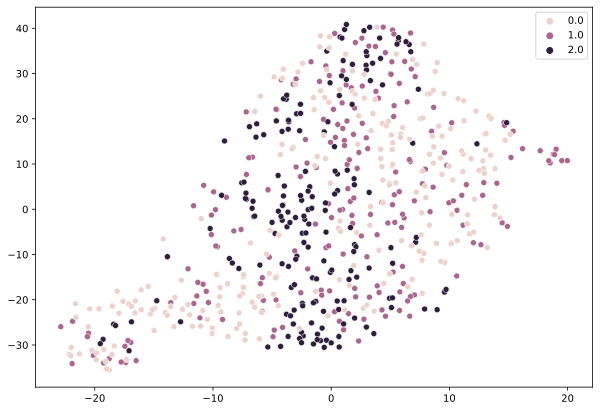

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x = t_SNE[:, 0], y = t_SNE[:, 1],
    hue = t_SNE[:, 2],
    legend="full"
)

From this plot, we can tell that audio = 2.0, namely audio file 008-1 obviously falls into the middle area while other audio files spread across the whole canvas.

## Use umap to reduce dimension of wav2vec embedding

In [ ]:
mapper = umap.UMAP().fit(num_three)

<AxesSubplot:>

<Figure size 720x360 with 0 Axes>

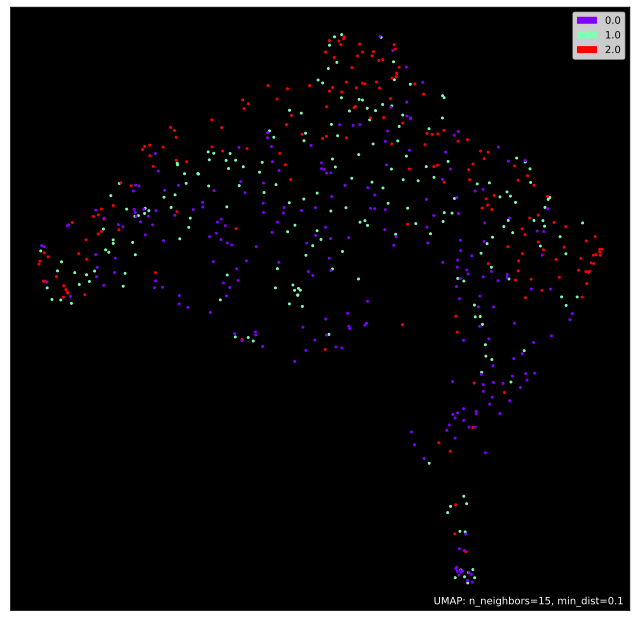

In [ ]:
plt.figure(figsize=(10, 5))
umap.plot.points(mapper, labels = ind[:,0], theme='fire')

From this umap dimension reduction, we can find that three audio embeddings have the same pattern and mix together.

## Use kMeans to cluster three audio embedding together

> Hyperparameter tuning using the silhouette score method:
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

### Below function is cited from the website: https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240

In [ ]:
def kmean_hyper_param_tuning(data):
    """
    Hyper parameter tuning to select the best from all the parameters on the basis of silhouette_score.
    :param data: dimensionality reduced data after applying PCA
    :return: best number of clusters for the model (used for KMeans n_clusters)
    """
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []

    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p

        ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores

        print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']

Parameter: {'n_clusters': 2} Score 0.530011
Parameter: {'n_clusters': 3} Score 0.46192276
Parameter: {'n_clusters': 4} Score 0.40278906
Parameter: {'n_clusters': 5} Score 0.39819413
Parameter: {'n_clusters': 10} Score 0.37270403
Parameter: {'n_clusters': 15} Score 0.3678001
Parameter: {'n_clusters': 20} Score 0.3609195
Parameter: {'n_clusters': 25} Score 0.3587734
Parameter: {'n_clusters': 30} Score 0.35212797
Parameter: {'n_clusters': 35} Score 0.3566004
Parameter: {'n_clusters': 40} Score 0.35228357


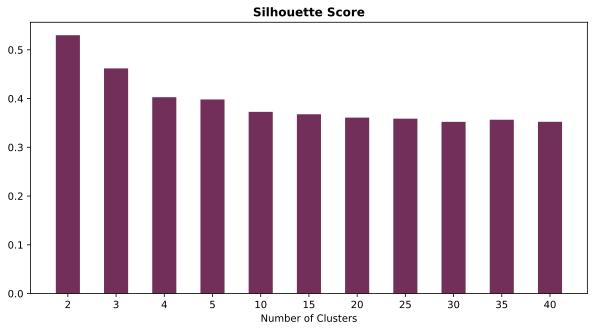

2

In [ ]:
# Use previously generated 2d embedding reduced by t-SNE
kmean_hyper_param_tuning(t_SNE_three)

We found that 2 clusters are the highest silhouette score, so we use two clusters for three audio 2d embedding.

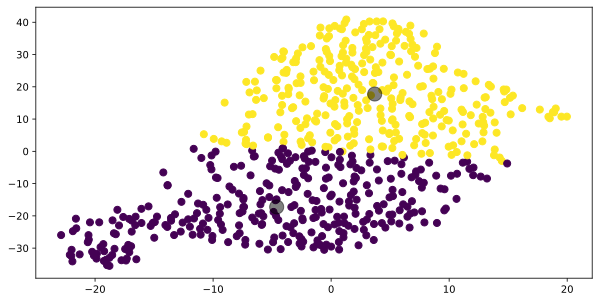

In [ ]:
#X = umap.UMAP().fit_transform(num_three)
X = t_SNE_three
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

We found that two cluster is well divided.

### Use the same process to decide the best cluster number for umap reduced dimension method

Parameter: {'n_clusters': 2} Score 0.47879595
Parameter: {'n_clusters': 3} Score 0.450327
Parameter: {'n_clusters': 4} Score 0.46941367
Parameter: {'n_clusters': 5} Score 0.4563045
Parameter: {'n_clusters': 10} Score 0.4160843
Parameter: {'n_clusters': 15} Score 0.40477595
Parameter: {'n_clusters': 20} Score 0.4004467
Parameter: {'n_clusters': 25} Score 0.3913185
Parameter: {'n_clusters': 30} Score 0.39175707
Parameter: {'n_clusters': 35} Score 0.3929347
Parameter: {'n_clusters': 40} Score 0.400749


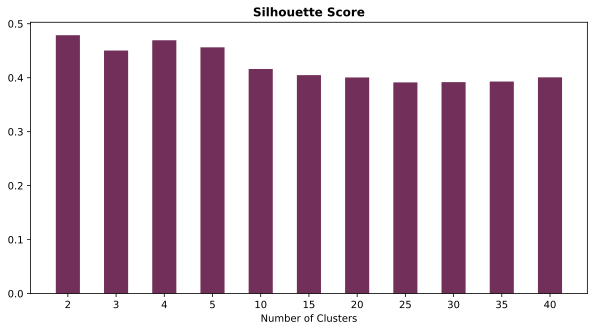

2

In [ ]:
kmean_hyper_param_tuning(umap.UMAP().fit_transform(num_three))

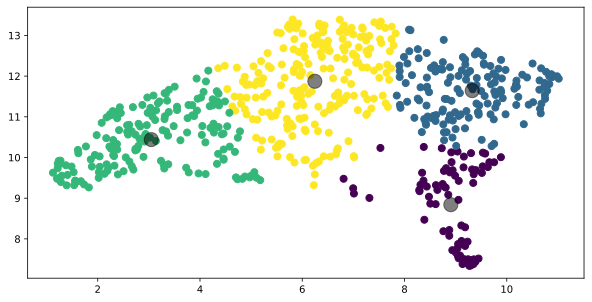

In [ ]:
X = umap.UMAP().fit_transform(num_three)
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In this case, cluster 2 and cluster 4 have very similar silhouette score, and I chose 4 clusters because as we know we have typical hour labels for our transcripts. We wish we could use four cluster to correspond to our manual four labels. Each cluster here represents one label groups, reprimand, praise, neutral, opportunity to response.